## Notebook to preprocess data from the Force perturbation center-out (CO) task

### First imports

In [1]:
### Imports

import pandas as pd
import numpy as np
import xarray as xr

import os
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Navigate up two levels to reach the grandparent directory (CL Control)
parent_dir = os.path.abspath(os.path.join('..',))
sys.path.append(parent_dir)

from src.helpers import *
from sklearn.metrics import *

import pickle
import math

import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

from pyaldata import *

from src.visualize import *

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
data_dir = "../Data"
fname = os.path.join(data_dir, "Chewie_CO_FF_2016-10-07.mat")
name = 'Chewie'
date = '1007'
path_to_save_data = os.path.join(data_dir, 'Processed_Data', 'Tidy_'+name+'_'+str(date)+'.pkl')

In [3]:
# Load TrialData .mat file into a DataFrame
df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') 

### Start preprocessing

a) For now combining bins to have 20ms instead of 10ms long windows to compute firing rate and velocity. We will see later if it should be done or not but we leave it as it may affect the thresholds for low-firing neurons and other functions.

In [4]:
# Combine time-bins into longer ones
td = combine_time_bins(df, 2)

b) Remove low-firing neurons. This function uses a threshold which is in Hz. 
As the threshold is 5Hz, that means that in 20ms bin we need at least 1 spike.
The function removes all neurons with an average firing rate below the threshold.

`Note` I am not sure if the threshold should be adjusted. With this threshold we remove 23/70 neurons ( so 33% ), whereas in the other dataset it was only 4/64. 

In [5]:
# Remove low-firing neurons
td = remove_low_firing_neurons(td, "M1_spikes",  5, divide_by_bin_size=True, verbose=True)
td = remove_low_firing_neurons(td, "PMd_spikes", 5, divide_by_bin_size=True, verbose=True)
print("original: ", df.M1_spikes[0].shape)
print("removed:  ", td.M1_spikes[0].shape)

Removed 23 neurons from M1_spikes.
Removed 54 neurons from PMd_spikes.
original:  (359, 70)
removed:   (179, 47)


c) Transform signals to get the SQRT

In [6]:
# Transform signals
td_2 = transform_signal(td, "M1_spikes",  'sqrt')
td_2 = transform_signal(td_2, "PMd_spikes", 'sqrt')

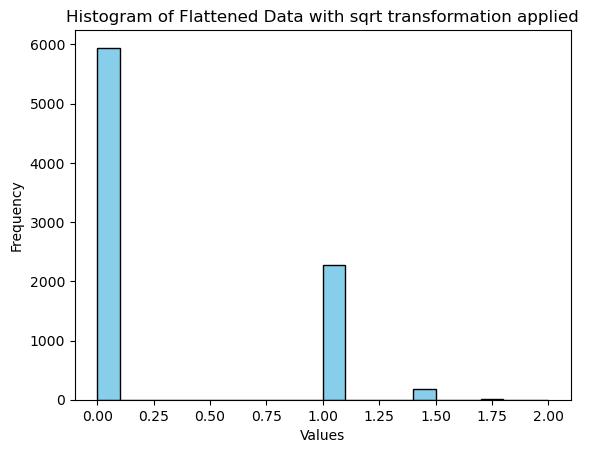

Mean :  0.304  Variance :  0.226


In [7]:
flattened_data_td2 = td_2.M1_spikes[0].flatten()

# Plot histogram
plt.hist(flattened_data_td2, bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Flattened Data with sqrt transformation applied')

# Show plot
plt.show()
print('Mean : ' ,np.round(flattened_data_td2.mean(), 3), ' Variance : ', np.round(flattened_data_td2.var(), 3))

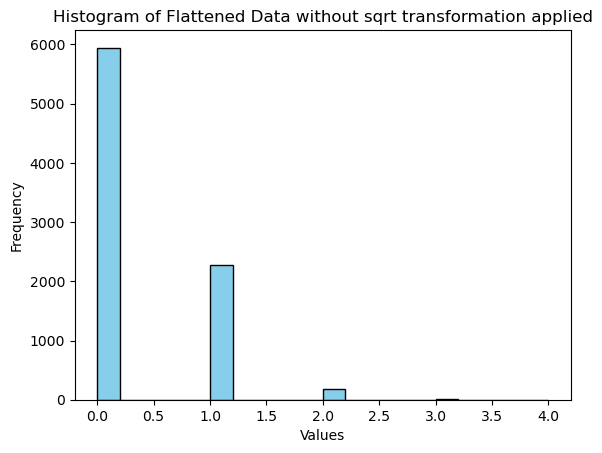

Mean :  0.318  Variance :  0.271


In [8]:
flattened_data = td.M1_spikes[0].flatten()

# Plot histogram
plt.hist(flattened_data, bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Flattened Data without sqrt transformation applied')

# Show plot
plt.show()
print('Mean : ' ,np.round(flattened_data.mean(), 3), ' Variance : ', np.round(flattened_data.var(), 3))

Overall, while the square root transformation is not always necessary or appropriate, it can be a valuable preprocessing step for neural data analysis, helping to address issues related to variance stabilization, linearity, and normalization.

d) Merge signals

Signals from the pre-motor and motor cortex are now combines in one same variable,  we do not consider the 2 regions as different but more as functionally working together.


In [9]:
td = merge_signals(td_2, ["M1_spikes", "PMd_spikes"], "both_spikes")

e) Compute firing rates. 

The way this is done is:
- First the std is defined or computed (the default value is 0.05)
- Then the std and the bin size are used to compute the gaussian window
- This window is used to compute a 1d convolution with each train of spikes and hence smooth and compute the firing rates per neuron.

To understand the effect of the window size in the models performances we will compute the firing rates twice, using different std.

In [10]:
# Compute firing rates standard mode
td = add_firing_rates(td, 'smooth', std = 0.05)
td_2 = add_firing_rates(td, 'smooth', std = 0.025)

# Add the variable with the thinner gaussian window to compute the firing rates.
td['both_rates_2'] = td_2['both_rates']  

f) Keep only rewarded trials

In [11]:
td = td.loc[td.result == 'R'].reset_index()

g) Trial length: how to find windows of the same length for the trials?

First idea: check the peak velocity and take values around this point

In [12]:
trial_lengths = [td.vel[i].shape[0] for i in range(len(td.vel))]

In [13]:
min_l = np.min(trial_lengths)
max_l = np.max(trial_lengths)
print('Minimum trial length: ', min_l, ' Maximum trial length : ', max_l)

Minimum trial length:  137  Maximum trial length :  588


In [14]:
indices = [index for index, value in enumerate(trial_lengths) if value < 175]
len(indices)

110

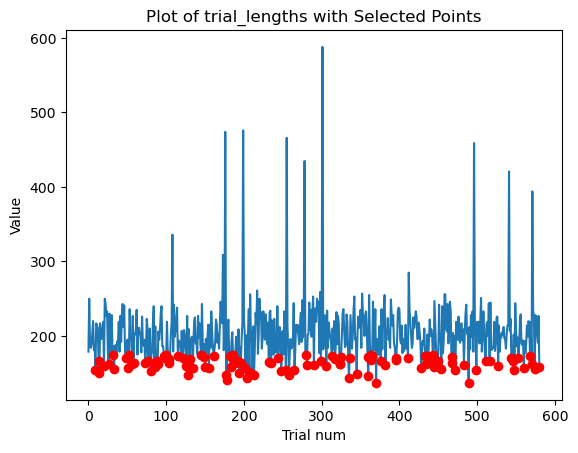

In [15]:
import matplotlib.pyplot as plt

# Plotting trial_lengths
plt.plot(trial_lengths)

# Plotting specific points using indices
plt.plot(indices, [trial_lengths[i] for i in indices], 'ro')  # 'ro' plots red circles

plt.xlabel('Trial num')
plt.ylabel('Value')
plt.title('Plot of trial_lengths with Selected Points')
plt.show()


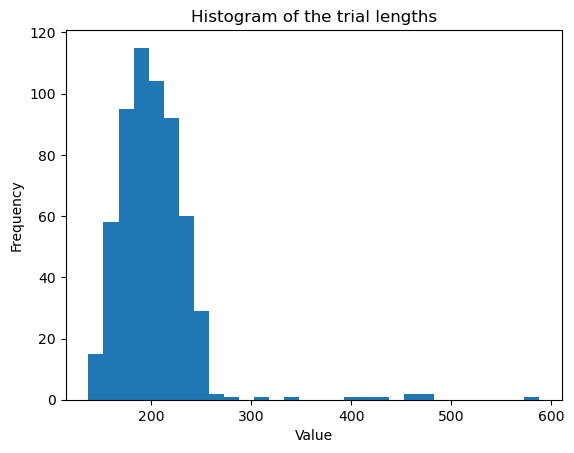

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some random data
data = trial_lengths

# Compute the histogram
hist, bins = np.histogram(data, bins=30)

# Plotting the histogram
plt.hist(data, bins=bins)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the trial lengths')
plt.show()

53


Text(0.5, 1.0, 'Trial split for the different parts of the movement')

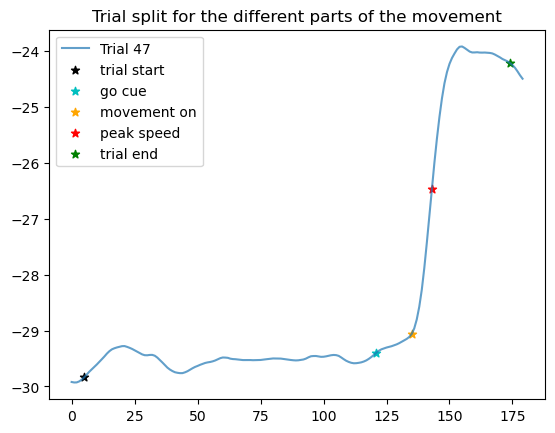

In [17]:
trial_num = 47

plt.plot(td.pos[trial_num][:,1], label = 'Trial ' + str(trial_num), alpha = 0.7)
plt.scatter(td.idx_trial_start[trial_num],td.pos[trial_num][td.idx_trial_start[trial_num],1] , c = 'k', marker= '*', label = 'trial start')
plt.scatter(td.idx_go_cue[trial_num],td.pos[trial_num][td.idx_go_cue[trial_num],1] , c = 'c', marker= '*', label = 'go cue')
plt.scatter(td.idx_movement_on[trial_num],td.pos[trial_num][td.idx_movement_on[trial_num],1] , c = 'orange', marker= '*', label = 'movement on')
plt.scatter(td.idx_peak_speed[trial_num],td.pos[trial_num][td.idx_peak_speed[trial_num],1] , c = 'r', marker= '*', label = 'peak speed')
plt.scatter(td.idx_trial_end[trial_num],td.pos[trial_num][td.idx_trial_end[trial_num],1] , c = 'g', marker= '*', label = 'trial end')
plt.legend()
print(td.idx_trial_end[trial_num] - td.idx_go_cue[trial_num])
plt.title('Trial split for the different parts of the movement')

Most of the movement of interest is between the go cue and the end of the trial. We need to make sure that the distance between those two is not too different from trial to trial and check the maximum distance so we can take the last part of the trials using this value.

In [18]:
dur_trial = [td.idx_trial_end[i] - td.idx_go_cue[i] for i in range(len(td))]
np.max(dur_trial)

75

There is no trial with a distance bigger than 75 samples, so we can say we use the last 100 samples from each trial and we should be able to get all necessary data.

In [19]:
variables_to_cut = ['pos', 'vel', 'M1_rates', 'PMd_rates', 'both_rates', 'both_rates_2']
for i in variables_to_cut:
    td[i] = td[i].apply(lambda x: x[-100:])

Now we want to concatenate all trials one after the other.

In [20]:
td = td.explode(['pos', 'vel', 'M1_rates', 'PMd_rates', 'both_rates', 'both_rates_2']).reset_index()

In [21]:
td.loc[td.trial_id == 5][['trial_id', 'pos', 'vel']].head(3)

,trial_id,pos,vel
200,5,"[0.17819852235245115, -30.055449847498167]","[0.858193349977317, 0.9150490725092748]"
201,5,"[0.1998603841915525, -30.03645001503957]","[1.2472336587016735, 0.8915203018606699]"
202,5,"[0.22581833701365284, -30.019478346993672]","[1.1917484688647204, 0.8710352080699665]"


### Data augmentation for linear decoders

Data augmentation to account for the neural activity up to 100ms before the position/movement. 
We build 5 new timeseries, each one starting 20ms after. We pad the data using the first sample.

In [22]:
tidy_df = td.copy()

In [23]:
tidy_df['both_rates1'] = pd.concat([tidy_df.both_rates[:1], tidy_df.both_rates[:-1]]).reset_index().drop(columns = 'index')
tidy_df['both_rates2'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1],  tidy_df.both_rates[:-2]]).reset_index().drop(columns = 'index')
tidy_df['both_rates3'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1],tidy_df.both_rates[:1],  tidy_df.both_rates[:-3]]).reset_index().drop(columns = 'index')
tidy_df['both_rates4'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:-4]]).reset_index().drop(columns = 'index')
tidy_df['both_rates5'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1], tidy_df.both_rates[:-5]]).reset_index().drop(columns = 'index')

In [24]:
tidy_df['both_rates_21'] = pd.concat([tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:-1]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_22'] = pd.concat([tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1],  tidy_df.both_rates_2[:-2]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_23'] = pd.concat([tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1],  tidy_df.both_rates_2[:-3]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_24'] = pd.concat([tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:-4]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_25'] = pd.concat([tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:-5]]).reset_index().drop(columns = 'index')

In [25]:
def extend_cols(x, main_col, cols):
    data = x[main_col]
    for c in cols:
        data = np.concatenate([data, x[c]])
    return data

In [26]:
tidy_df['both_rates_augmented'] = tidy_df[['both_rates', 'both_rates1', 
                                      'both_rates2', 'both_rates3', 
                                      'both_rates4', 'both_rates5']].apply(lambda x: extend_cols(x, 'both_rates', 
                                                                                                   ['both_rates1', 'both_rates2', 
                                                                                                    'both_rates3', 'both_rates4', 
                                                                                                    'both_rates5']), axis = 1)

In [27]:
tidy_df['both_rates_augmented_2'] = tidy_df[['both_rates_2', 'both_rates_21', 
                                      'both_rates_22', 'both_rates_23', 
                                      'both_rates_24', 'both_rates_25']].apply(lambda x: extend_cols(x, 'both_rates_2', 
                                                                                                   ['both_rates_21', 'both_rates_22', 
                                                                                                    'both_rates_23', 'both_rates_24', 
                                                                                                    'both_rates_25']), axis = 1)

In [28]:
tidy_df.rename(columns={'trial_id': 'id'}, inplace=True)

In [29]:
with open(path_to_save_data, 'wb') as handle:
            pickle.dump(tidy_df, handle, protocol=4)

## Baseline Models

First, we will go for models of the baseline trials, that is the trials for which there is not a force perturbation.

In [30]:
tidy_df.epoch.unique()

array(['BL', 'AD', 'WO'], dtype=object)

In [31]:
baseline_df = tidy_df.loc[tidy_df['epoch'] == 'BL']

### Train-Test split

In [32]:
X_train, y_train, X_val, y_val, X_test,\
      y_test, info_train, info_val,\
          info_test, mins, maxs = train_test_split(baseline_df,\
                                                    train_variable = 'both_rates_augmented', 
                                                    target_variable = 'vel', num_folds = 5)

Train trials 109
Test trials  34
Val trials 27


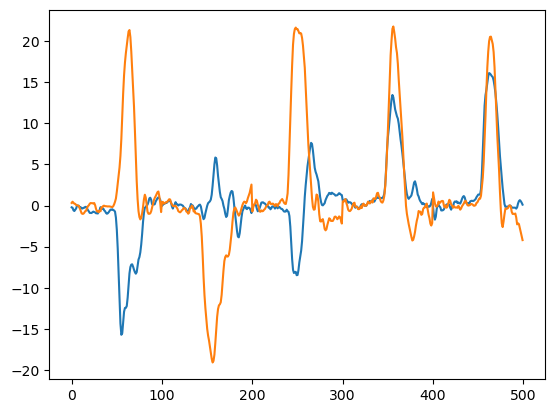

In [33]:
plt.plot(y_val['fold0'][:500])

## Linear Decoder

In [34]:
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, FactorAnalysis

In [35]:
import numpy as np

alphas = np.logspace(0, 3, 50)


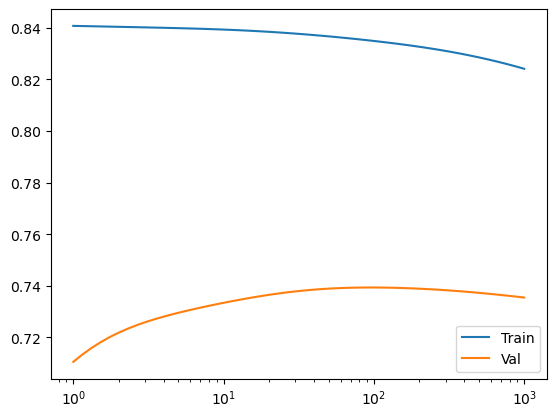

In [36]:
num_folds = 5
dim_reduce = False
num_dim = 10

alphas = np.logspace(0, 3, 50)

test_score = []
train_score = []
best_a = []

for i in range(num_folds):
    train_score_a = []
    val_score_a = []

    best_score = -np.inf  # Initialize best score to negative infinity
    best_model = None

    for a in alphas:
        if dim_reduce == True:

            PCA_model = PCA(num_dim).fit(X_train['fold'+str(i)])
            X_train_ = PCA_model.transform(X_train['fold'+str(i)])
            X_val_ = PCA_model.transform(X_val['fold'+str(i)])
            X_test_ = PCA_model.transform(X_test['fold'+str(i)])
        else:
            X_train_ = X_train['fold'+str(i)]
            X_val_ = X_val['fold'+str(i)]
            X_test_ = X_test['fold'+str(i)]

        model = Ridge(alpha = a, fit_intercept=True)
        model.fit(X_train_, y_train['fold'+str(i)])
        score = model.score(X_val_, y_val['fold'+str(i)])
        train_score_a.append(model.score(X_train_, y_train['fold'+str(i)]))
        val_score_a.append(score)

        # Check if current model has better validation score than previous best
        if score > best_score:
            best_score = score
            best_model = model
    if i == 1:
        plt.plot(alphas, train_score_a, label = 'Train')
        plt.plot(alphas, val_score_a, label = 'Val')
        plt.xscale('log')
        plt.legend()

    best_a.append(alphas[np.argmax(val_score_a)])
    test_score.append(best_model.score(X_test_, y_test['fold'+str(i)]))
    train_score.append(best_model.score(X_train_, y_train['fold'+str(i)]))


In [37]:
best_a

[79.06043210907697,
 91.02981779915218,
 212.09508879201903,
 138.94954943731372,
 281.1768697974231]

In [38]:
np.mean(test_score)

0.7623658353483883

In [39]:
np.mean(train_score)

0.8321771907842429

I have used both the features computed with the thinner gaussian window and the ones with the default (0.05 std), and the results are better with the default one.

#### Now running the model with the best alpha

In [40]:
fold = 0
model = Ridge(alpha = best_a[fold], fit_intercept=True)
model.fit(X_train['fold'+str(fold)], y_train['fold'+str(fold)])

Ridge(alpha=79.06043210907697)

In [41]:
y_pred_linear = model.predict(X_val['fold'+str(fold)])

In [42]:
def visualize_LSTM_test(y_hat, y_true, seq_length):

    y_hat = y_hat.reshape(y_hat.shape[0] // seq_length, seq_length, y_hat.shape[1])  
    y_true = y_true.reshape(y_true.shape[0] // seq_length, seq_length, y_true.shape[1])  
    
    num_trials = y_hat.shape[0]
    # Define time vector (assuming each sample represents 20ms)
    trial_len = y_true.shape[1]
    time_vector = np.arange(0, trial_len * 0.02, 0.02)  # Time vector in seconds

    # Create a figure and axis objects
    fig, ax = plt.subplots(nrows=2, ncols=5, sharey='row', figsize=[4*5, 10])

    # Plot the signals with vertical spacing
    spacing = 0.5  # Adjust the spacing value as desired

    # Define a list of colors
    colors = ['g', 'b', 'orange']

    # Plot each variable (x, y, z) in separate rows
    for j in range(num_trials)[:5]:
        data = y_true[j]
        pred_data = y_hat[j]
        
        # Plot x variable
        ax[0, j].plot(time_vector, data[:, 0], c=colors[0], label='True')
        ax[0, j].plot(time_vector, pred_data[:, 0], c=colors[0], alpha=0.5, linestyle='--', label='Predicted')
        ax[0, j].set_title('Trial {}'.format(j+1), fontsize='xx-large')
        ax[0, j].spines[['right', 'top', 'left']].set_visible(False)
        
        # Plot y variable
        ax[1, j].plot(time_vector, data[:, 1], c=colors[1])
        ax[1, j].plot(time_vector, pred_data[:, 1], c=colors[1], alpha=0.5, linestyle='--')
        ax[1, j].spines[['right', 'top', 'left']].set_visible(False)
        


    # Set y-label only for the first column
    fig.text(0.075, 0.78, 'X Position', va='center', rotation='vertical', fontsize = 16)
    fig.text(0.075, 0.5, 'Y Position', va='center', rotation='vertical', fontsize = 16)



    # Create a common legend for all subplots
    handles, labels = ax[0, 0].get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2, fontsize='large')
    for line in legend.get_lines():
        line.set_color('k')  # Set legend line color to red

    plt.subplots_adjust(hspace=0.5)

    # Show the plot
    plt.show()

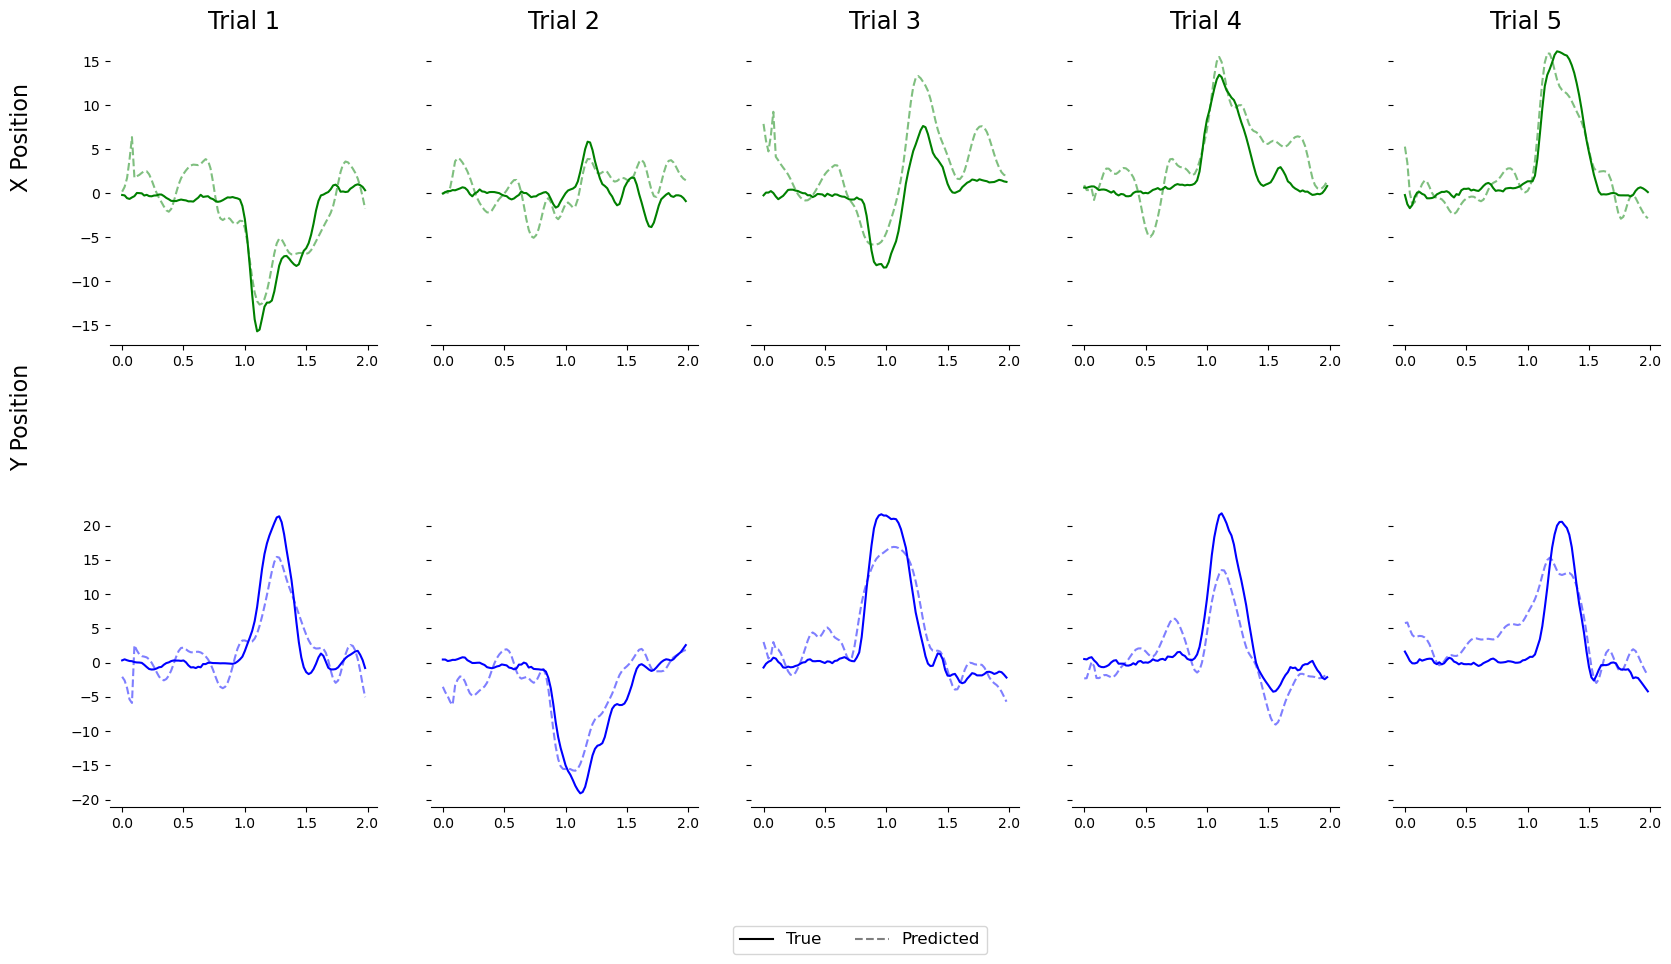

In [43]:
visualize_LSTM_test(y_pred_linear, y_val['fold'+str(fold)], seq_length = 100)

## Non-linear model

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

from src.trainer import *
from src.regularizers import *

In [45]:
X_train, y_train, X_val, y_val, X_test, y_test,\
     info_train, info_val, info_test, mins, \
        maxs = train_test_split(baseline_df, train_variable = 'both_rates',\
        target_variable = 'vel', num_folds = 5)

Train trials 109
Test trials  34
Val trials 27


In [46]:
adaptation_df = tidy_df.loc[tidy_df['epoch'] == 'AD']

In [47]:
X_train_ad, y_train_ad, X_val_ad, y_val_ad, X_test_ad, y_test_ad,\
     info_train_ad, info_val_ad, info_test_ad, mins_ad, \
        maxs_ad = train_test_split(adaptation_df, train_variable = 'both_rates',\
        target_variable = 'vel', num_folds = 5)

Train trials 129
Test trials  40
Val trials 32


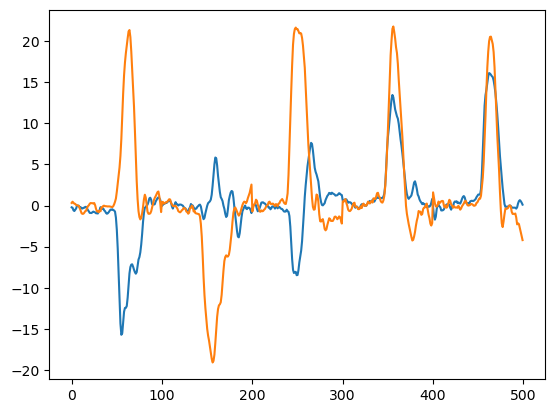

In [48]:
plt.plot(y_val['fold0'][:500])

In [49]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)


X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seq_length = 100

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

seed = 42
torch.manual_seed(seed)

We are testing the optimization method on fold  0


In [50]:
xx_train.shape

(109, 100, 130)

In [69]:
class Model(nn.Module):
    def __init__(self, num_features=124, 
                hidden_units= 3, #was 128
                num_layers = 2, 
                out_dims = 6,
                dropout = 0.5):
        super(Model, self).__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.out_dims = out_dims
        self.dropout = dropout

        # self.rnn = nn.RNN(
        #     input_size = self.num_features, 
        #     hidden_size = self.hidden_units, 
        #     num_layers = self.num_layers, 
        #     nonlinearity='tanh', bias= True, 
        #     batch_first= True, dropout=0.0, 
        #     bidirectional=False,)  
        
        self.lstm = nn.LSTM(
            input_size= self.num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers= num_layers, bias= True, 
            bidirectional=False,)
        
        self.selu = nn.SELU()
    
        self.linear = nn.Linear(in_features=self.hidden_units, out_features= self.out_dims)

        self.dropout = nn.Dropout(p= dropout) #trial.suggest_float('dropout_1', 0.1, 0.9)
        
        # Flatten the parameters
        #self.rnn.flatten_parameters()
        self.lstm.flatten_parameters()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.selu(x) 
        output = self.linear(x)

        return output.squeeze()

In [70]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

lr = 0.00001
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 300
num_layers = 1
#input_size = 49
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 25
batch_size_val = 25

torch.manual_seed(42)

In [71]:
# Fit the LSTM model
model = Model(num_features=num_features, 
                    hidden_units= hidden_units, #was 128
                    num_layers = num_layers, 
                    out_dims = num_dim_output, 
                    dropout = dropout ).to(device)

In [72]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [73]:
model.apply(weight_reset)

Model(
  (lstm): LSTM(130, 300, batch_first=True)
  (selu): SELU()
  (linear): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [74]:
train_losses, val_losses = \
    train_model(model, xx_train,yy_train,
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer = Regularizer_LSTM,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                )

Decrease LR
Decrease LR
68


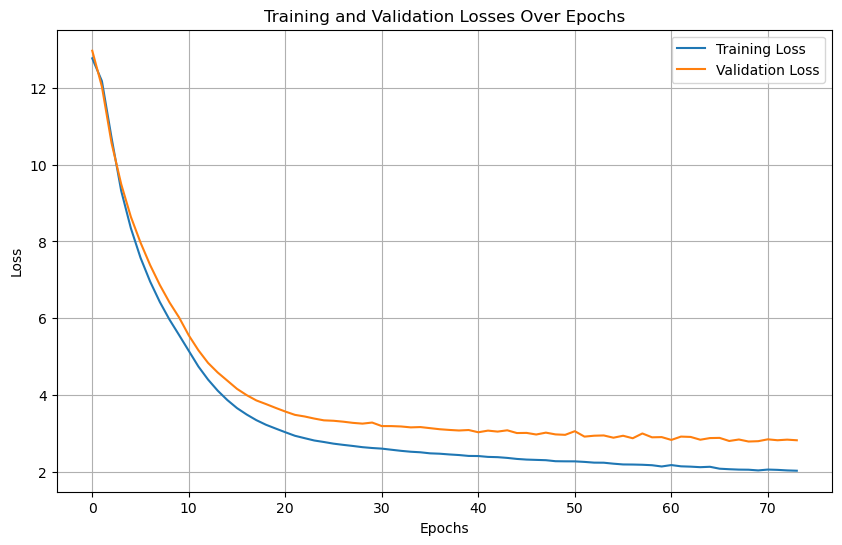

In [75]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [76]:
def reshape_to_eval(x,y, model):
    # Convert X_train and y_train to PyTorch tensors
    inputs = torch.tensor(x, device=device, dtype=torch.float32)
    targets = torch.tensor(y, device=device, dtype=torch.float32)

    y_pred = model(inputs)
    y_array = targets.detach().cpu().numpy()
    y_pred_array = y_pred.detach().cpu().numpy()

    # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
    y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
    y_true_2D = y_array.reshape(-1, y_array.shape[-1])
    
    return y_true_2D, y_pred_2D



def eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'rmse'):

    #Move tensors to cpu and reshape them for evaluation
    y_true_train, y_pred_train = reshape_to_eval(xx_train,yy_train, model)
    y_true_val, y_pred_val = reshape_to_eval(xx_val,yy_val, model)
    y_true_test, y_pred_test = reshape_to_eval(xx_test,yy_test, model)

    if metric == 'rmse':
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(y_true_train, y_pred_train))
        print('Train Score: %.2f RMSE' % (trainScore))
        valScore = math.sqrt(mean_squared_error(y_true_val, y_pred_val))
        print('Val Score: %.2f RMSE' % (valScore))
        testScore = math.sqrt(mean_squared_error(y_true_test, y_pred_test))
        print('Test Score: %.2f RMSE' % (testScore))

        return y_pred_test, y_true_test,trainScore, valScore, testScore
    
    elif metric == 'ev':
        #Compute explained variance
        ev_train = explained_variance_score(y_true_train, y_pred_train)
        ev_val = explained_variance_score(y_true_val, y_pred_val)
        ev_test = explained_variance_score(y_true_test, y_pred_test)
        print('Train EV: %.2f ' % (ev_train))
        print('Val EV: %.2f ' % (ev_val))
        print('Test EV: %.2f ' % (ev_test))
        return y_pred_val, y_true_val, ev_train, ev_val, ev_test

In [77]:
inputs = torch.tensor(xx_val, device=device, dtype=torch.float32)
targets = torch.tensor(yy_val, device=device, dtype=torch.float32)

In [78]:
y_array = targets.detach().cpu().numpy()

In [79]:
y_true_2D = y_array.reshape(-1, y_array.shape[-1])

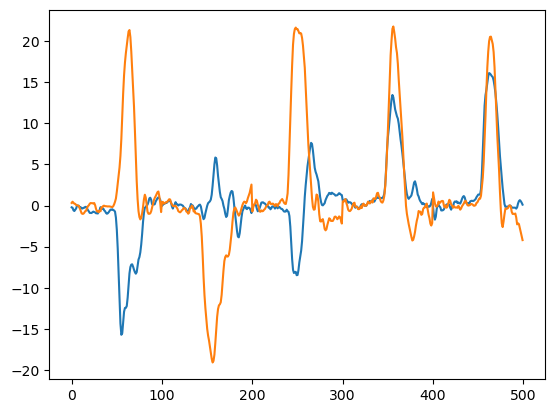

In [80]:
plt.plot(y_true_2D[:500,:])

In [81]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.94 
Val EV: 0.88 
Test EV: 0.86 


In [62]:
import copy

In [63]:
#model_RNN = copy.deepcopy(model)

In [82]:
model_LSTM = copy.deepcopy(model)

In [83]:
y_hat_RNN, y_true_RNN, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model_RNN, metric = 'ev')
y_hat_LSTM, y_true_LSTM, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model_LSTM, metric = 'ev')

Train EV: 0.94 
Val EV: 0.90 
Test EV: 0.89 
Train EV: 0.94 
Val EV: 0.88 
Test EV: 0.86 


/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/torch/nn/modules/rnn.py:554: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /opt/conda/conda-bld/pytorch_1711403382592/work/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/torch/nn/modules/rnn.py:554: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /opt/conda/conda-bld/pytorch_1711403382592/work/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat

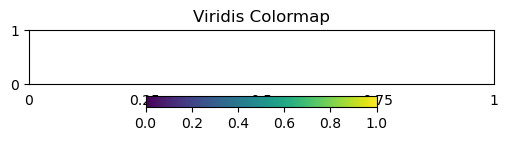

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))

# Create a ScalarMappable with the Viridis colormap
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))

# Fake invisible image to create a colorbar
sm.set_array([])
plt.colorbar(sm, orientation='horizontal', ax=ax)

# Set labels and show the plot
ax.set_title('Viridis Colormap')
ax.set_xticks(np.linspace(0, 1, 5))  # Adjust ticks as needed
ax.set_xticklabels(['0', '0.25', '0.5', '0.75', '1'])  # Labels for ticks
ax.xaxis.set_ticks_position('none')  # Hide ticks

plt.show()


In [101]:
plt.set_cmap('viridis')  # Example of setting a colormap

<Figure size 640x480 with 0 Axes>

In [141]:
def visualize_all_models(y_hat1, y_true1, y_hat2,
                        y_hat3, seq_length):

    y_hat1 = y_hat1.reshape(y_hat1.shape[0] // seq_length, seq_length, y_hat1.shape[1])  
    y_true1 = y_true1.reshape(y_true1.shape[0] // seq_length, seq_length, y_true1.shape[1])  
    y_hat2 = y_hat2.reshape(y_hat2.shape[0] // seq_length, seq_length, y_hat2.shape[1])      
    y_hat3 = y_hat3.reshape(y_hat3.shape[0] // seq_length, seq_length, y_hat3.shape[1])  
    
    num_trials = y_hat1.shape[0]
    # Define time vector (assuming each sample represents 20ms)
    trial_len = y_true1.shape[1]
    time_vector = np.arange(0, trial_len * 0.02, 0.02)  # Time vector in seconds

    # Create a figure and axis objects
    fig, ax = plt.subplots(nrows=2, ncols=5, sharey='row', figsize=[4*5, 10])

    # Plot the signals with vertical spacing
    spacing = 0.5  # Adjust the spacing value as desired

    # Define a list of colors
    colors = ['b', 'green', 'orange']

    # Plot each variable (x, y, z) in separate rows
    for j in range(num_trials)[:5]:
        data1 = y_true1[j]
        pred_data1 = y_hat1[j]

        pred_data2 = y_hat2[j]

        pred_data3 = y_hat3[j]
        
        # Plot x variable
        ax[0, j].plot(time_vector, data1[:, 0], linewidth = 2.5, c='k', label='True')
        ax[0, j].plot(time_vector, pred_data1[:, 0], linewidth = 2.5, c=colors[0], alpha=0.6, linestyle='--', label='Predicted RNN')
    
        ax[0, j].plot(time_vector, pred_data2[:, 0], linewidth = 2.5, c=colors[1], alpha=0.6, linestyle='--', label='Predicted LSTM')

        ax[0, j].plot(time_vector, pred_data3[:, 0], linewidth = 2.5, c=colors[2], alpha=0.6, linestyle='--', label='Predicted Linear')
        ax[0, j].set_title('Trial {}'.format(j+1), fontsize='xx-large')
        ax[0, j].spines[['right', 'top', 'left']].set_visible(False)
        
        # Plot y variable
        ax[1, j].plot(time_vector, data1[:, 1], linewidth = 2.5, c='k', label='True')
        ax[1, j].plot(time_vector, pred_data1[:, 1], linewidth = 2.5, c=colors[0], alpha=0.6, linestyle='--', label='Predicted RNN')
     
        ax[1, j].plot(time_vector, pred_data2[:, 1], linewidth = 2.5, c=colors[1], alpha=0.6, linestyle='--', label='Predicted LSTM')

        ax[1, j].plot(time_vector, pred_data3[:, 1], linewidth = 2.5, c=colors[2], alpha=0.6, linestyle='--', label='Predicted Linear')
        ax[1, j].spines[['right', 'top', 'left']].set_visible(False)

        ax[1, j].set_xlabel("Time (s)", fontsize = 20)
        


    # Set y-label only for the first column
    fig.text(0.075, 0.7, 'X Velocity', va='center', rotation='vertical', fontsize = 25)
    fig.text(0.075, 0.3, 'Y Velocity', va='center', rotation='vertical', fontsize = 25)

    



    # Create a common legend for all subplots
    handles, labels = ax[0, 0].get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2, fontsize='xx-large')
    """for line in legend.get_lines():
        line.set_color('k')  # Set legend line color to red """

    plt.subplots_adjust(hspace=0.5)

    # Show the plot
    plt.show()

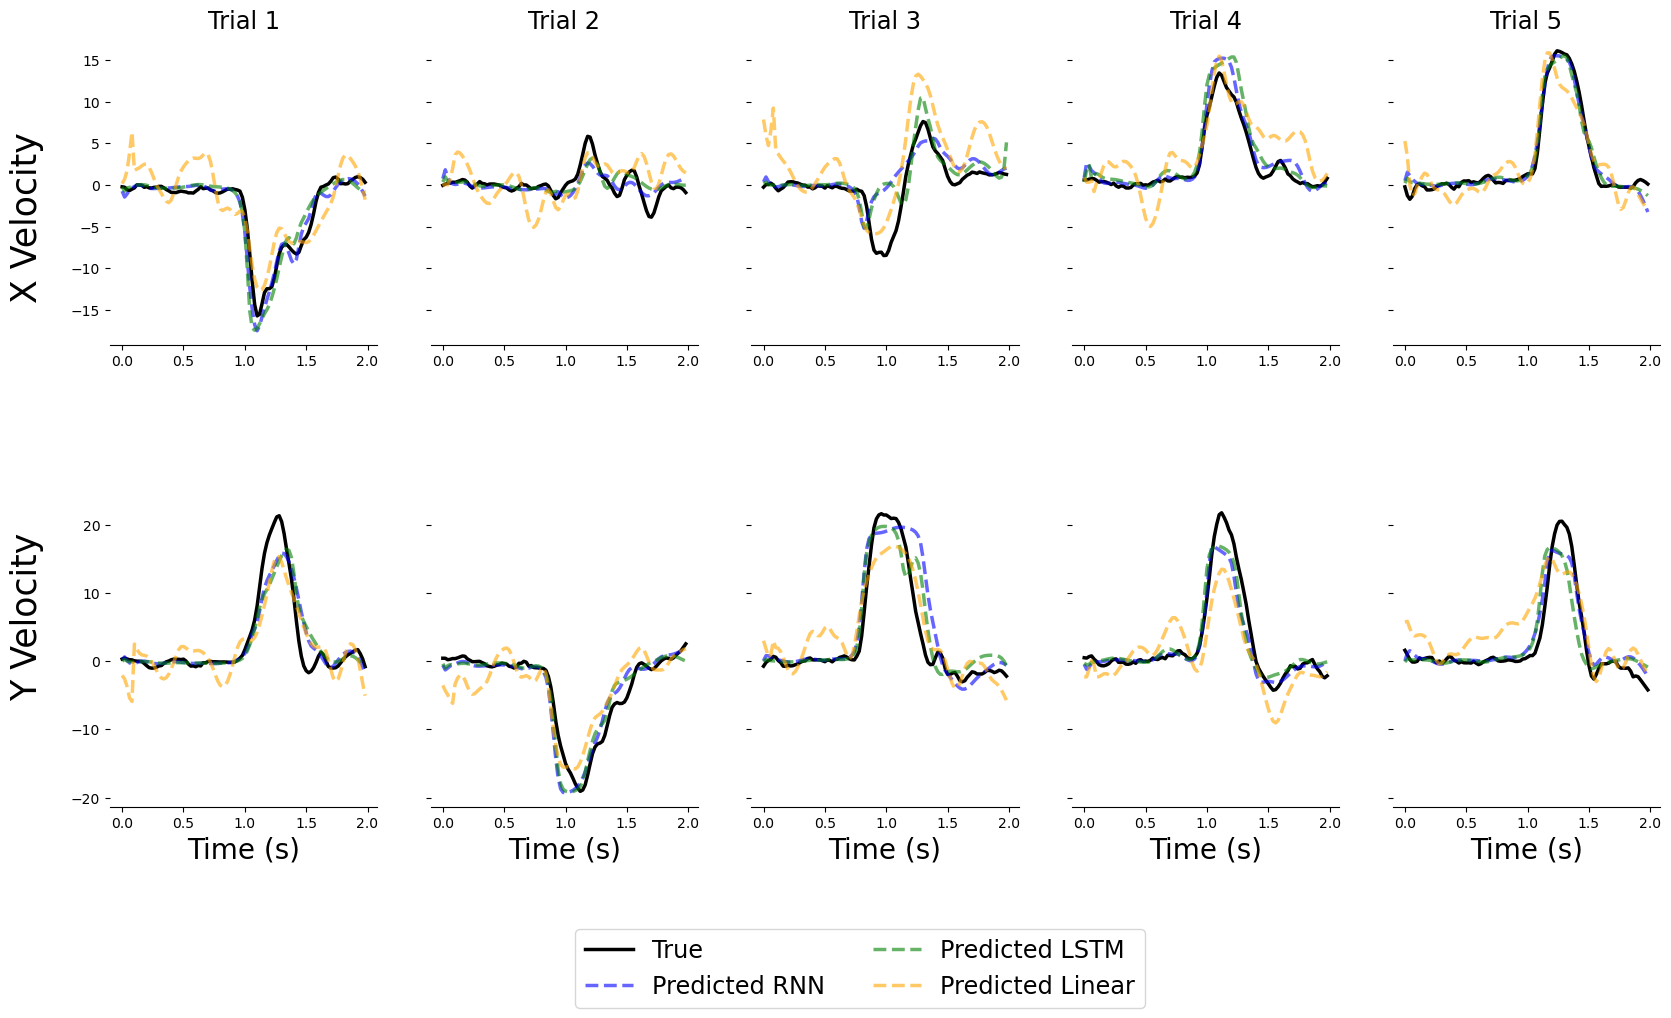

In [142]:
visualize_all_models(y_hat_RNN, y_true_RNN, \
                        y_hat_LSTM, 
                            y_pred_linear,   seq_length = 100)